# Машинное обучение с подкреплением. Сбербанк осень 2020.

## Семинар 1

### Обучение с подкреплением: OpenAI gym, CrossEntropy Method (CEM), Deep CEM.


Импортируем необходимые библиотеки и настраиваем визуализацию:


In [1]:
try:
    import colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !wget https://gist.githubusercontent.com/Tviskaron/4d35eabce2e057dd2ea49a00b00aaa41/raw/f1e25fc6ac6d8f11cb585559ce8b2ab9ffefd67b/colab_render.sh -O colab_render.sh -q
    !sh colab_render.sh
    !wget https://gist.githubusercontent.com/Tviskaron/d91decc1ca5f1b09af2f9f080011a925/raw/0d3474f65b4aea533996ee00edf99a37e4da5561/colab_render.py -O colab_render.py -q 
    import colab_render

In [2]:
# библиотеки и функции, которые потребуеются для показа видео

import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
from gym.envs.classic_control import rendering
import matplotlib.pyplot as plt

%matplotlib inline


org_constructor = rendering.Viewer.__init__


def constructor(self, *args, **kwargs):
    org_constructor(self, *args, **kwargs)
    self.window.set_visible(visible=False)


rendering.Viewer.__init__ = constructor


def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

2024-03-18 00:31:56.986 Python[83162:2025448] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/ym/ydbkj0wn31s78k5ly_zg_n39tlsnf_/T/org.python.python.savedState


## 1. OpenAI Gym


[Gym](https://gym.openai.com) $-$ это набор инструментов для разработки и сравнения алгоритмов обучения с подкреплением, который также включает в себя большой [набор окружений](https://gym.openai.com/envs/).


### Создание окружения

Для создания окружения используется функция `gym.make(<имя окружения>)`.


In [3]:
import gymnasium as gym

# Создаем окружение
env = gym.make("MountainCar-v0")

# Инициализируем окружение
state = env.reset()
print(f"state: {state}")

# Выполняем действие в среде
next_state, r, done, info, _ = env.step(0)
print(f"next_state: {next_state} , r: {r}, done: {done}, info: {info}")

# Закрываем окружение
env.close()

state: (array([-0.56085306,  0.        ], dtype=float32), {})
next_state: [-0.5615742  -0.00072117] , r: -1.0, done: False, info: False


### Основные методы окружения:

- `reset()` $-$ инициализация окружения, возвращает первое наблюдение (состояние).
- `step(a)` $-$ выполнить в среде действие $\mathbf{a}$ и получить кортеж: $\mathbf{\langle s_{t+1}, r_t, done, info \rangle}$, где $\mathbf{s_{t+1}}$ - следующее состояние, $\mathbf{r_t}$ - вознаграждение, $\mathbf{done}$ - флаг заверешния, $\mathbf{info}$ - дополнительная информация

### Дополнительные методы:

- `render()` $-$ визуализация текущего состояния среды (удобно, если мы запускаем локально, в колабе ничего не увидим)

- `close()` $-$ закрывает окружение


### Свойства среды:

- `env.observation_space` $-$ информация о пространстве состояний
- `env.action_space` $-$ информация о пространстве действий


In [4]:
print(f"env.observation_space: {env.observation_space}")
print(f"env.action_space: {env.action_space}")

env.observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.action_space: Discrete(3)


### Среда `MountainCar-v0`

Информацию о любой среде можно найти в [исходниках](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py) или на [сайте](https://gym.openai.com/envs/MountainCar-v0/). О `MountainCar-v0` мы можем узнать следующее:

#### Задание:

Автомобиль едет по одномерному треку между двумя холмами. Цель состоит в том, чтобы заехать на правый холм; однако двигатель машины недостаточно мощный, чтобы взобраться на холм за один проход. Следовательно, единственный способ добиться успеха $-$ это двигаться вперед и назад, чтобы набрать обороты.

#### Пространство состояний Box(2):

| Num | Observation | Min   | Max  |
| --- | ----------- | ----- | ---- |
| 0   | position    | -1.2  | 0.6  |
| 1   | velocity    | -0.07 | 0.07 |

#### Пространство действий Discrete(3):

| Num | Action     |
| --- | ---------- |
| 0   | push left  |
| 1   | no push    |
| 2   | push right |

- Вознаграждения: -1 за каждый шаг, пока не достигнута цель

- Начальное состояние: Случайная позиция от -0.6 до -0.4 с нулевой скоростью.


### Пример со случайной стратегией:

Для выбора действия используется `env.action_space.sample()`


In [5]:
from gymnasium.wrappers.record_video import RecordVideo

video_index = "./video"

# создаем окружение
env = gym.make("MountainCar-v0", render_mode="rgb_array")
# добавляем wrapper (обертку), чтобы задать ограничение на число шагов в среде
env = gym.wrappers.TimeLimit(env, max_episode_steps=250)
# # добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, done, _, _ = env.step(env.action_space.sample())

env.close()

# Сначала закрываем окружение, чтобы видео записалось полностью
env.close()
show_video(video_index)

Moviepy - Building video /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4


### Задание 1:

В среде MountainCar-v0 мы хотим, чтобы машина достигла флага. Давайте решим эту задачу, не используя обучение с подкреплением. Модифицируйте код функции act() ниже для выполнения этого задания. Функция получает на вход состояние среды и должна вернуть действие.


In [38]:
def act(s):
    # список возможных действий
    left, stop, right = 0, 1, 2

    # позиция и скорость
    position, velocity = s
    if position < 0 and velocity < 0:
        return left
    if position < 0 and velocity >= 0:
        return right
    if position > 0 and velocity > 0:
        return right
    if position > 0 and velocity <= 0:
        return left

Проверяем решение:


In [39]:
env = gym.wrappers.TimeLimit(
    gym.make("MountainCar-v0", render_mode="rgb_array"), max_episode_steps=250
)
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s = env.reset()
s = list(s[0])
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, done, _, _ = env.step(act(s))

if s[0] > 0.47:
    print("Принято!")
else:
    print("""Исправьте функцию выбора действия!""")


env.close()
show_video(video_index)

Moviepy - Building video /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/p-kroychuk/Desktop/MFTI_DS/rl/video/rl-video-episode-0.mp4
Принято!


## 2. Crossentropy Method

В этой пункте мы посмотрим на то, как решить задачи RL с помощью метода crossentropy.

Рассмотрим пример с задачей Taxi [Dietterich, 2000].


In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

env = gym.make("Taxi-v3")
env.reset()
env.render()

/usr/local/lib/python3.11/site-packages/gymnasium/envs/toy_text/taxi.py:314: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Taxi-v3", render_mode="rgb_array")
  gym.logger.warn(


In [41]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"состояний: {n_states} действий: {n_actions}")

состояний: 500 действий: 6


В этот раз нашей стратегией будет вероятностной распределение.

$\pi(s,a) = P(a|s)$

Для задачи такси мы можем использовать таблицу:

policy[s,a] = P(выбрать действие a | в состоянии s)

Создадим "равномерную" стратегию в виде двумерного массива с
равномерным распределением по действиям и сгенерируем игровую сессию с такой стратегией


In [44]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((500, 6)) / 6
    return policy


policy = initialize_policy(n_states, n_actions)

In [45]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

4

### Генерация сессий взаимодейтсвия со средой.

Мы будем запоминать все состояния, действия и вознаграждения за эпизод.


In [56]:
def generate_session(env, policy, t_max=10**4):
    """
    Игра идет до конца эпизода или до t_max шагов в окружении.
    :param policy: [n_states,n_actions]
    :returns: states - список состояний, actions - список действий, total_reward - итоговое вознаграждение
    """
    states, actions = [], []
    total_reward = 0.0

    s = env.reset()
    s = s[0]

    for t in range(t_max):
        # Подсказка: вы можете использовать np.random.choice для сэмплирования
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        a = np.random.choice(a=6, p=policy[s])
        ####### Здесь ваш код ########
        # raise NotImplementedError
        ##############################
        new_s, r, done, info, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [59]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float32]

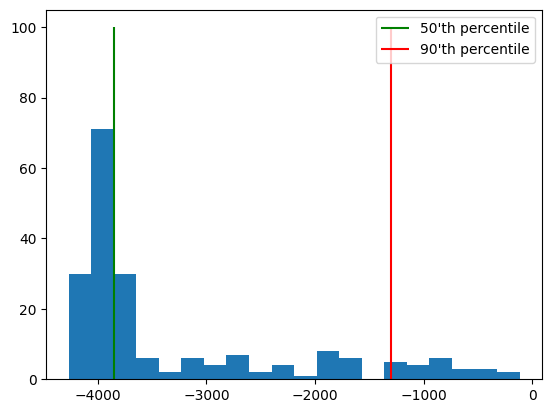

In [60]:
# посмотрим на изначальное распределение вознаграждения
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Реализация метода crossentropy

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшее вознаграждение:


In [78]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states, elite_actions - одномерные
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    reward_threshold = np.quantile(rewards_batch, q=percentile / 100)
    ####### Здесь ваш код ########
    # raise NotImplementedError
    ##############################

    # в соответствии с найденным порогом - отобрать
    # подходящие состояния и действия
    mask = rewards_batch >= reward_threshold
    elite_states = [states_batch[i] for i, flag in enumerate(mask) if flag]
    elite_actions = [actions_batch[i] for i, flag in enumerate(mask) if flag]
    ####### Здесь ваш код ########
    # raise NotImplementedError
    ##############################
    elite_states = [item for sublist in elite_states for item in sublist]
    elite_actions = [item for sublist in elite_actions for item in sublist]
    return elite_states, elite_actions

In [80]:
states_batch = [
    [1, 2, 3],  # game1
    [4, 2, 0, 2],  # game2
    [3, 1],  # game3
]

actions_batch = [
    [0, 2, 4],  # game1
    [3, 2, 0, 1],  # game2
    [3, 3],  # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), (
    "Для процентиля 0 необходимо выбрать все состояния "
    "и действия в хронологическом порядке"
)

assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), ("Для процентиля 30 необходимо выбрать " "состояния/действия из [3:]")
assert np.all(test_result_90[0] == [3, 1]) and np.all(test_result_90[1] == [3, 3]), (
    "Для процентиля 90 необходимо выбрать состояния " "действия одной игры"
)
assert np.all(test_result_100[0] == [3, 1]) and np.all(test_result_100[1] == [3, 3]), (
    "Проверьте использование знаков: >=,  >. " "Также проверьте расчет процентиля"
)
print("Тесты пройдены!")

Тесты пройдены!


Теперь мы хотим написать обновляющуюся стратегию:


In [82]:
def update_policy(elite_states, elite_actions):
    """
    Новой стратегией будет:
    policy[s_i,a_i] ~ #[вхождения  si/ai в лучшие states/actions]

    Не забудьте про нормализацию состояний.
    Если какое-то состояние не было посещено, 
    то используйте равномерное распределение 1./n_actions

    :param elite_states:  список состояний
    :param elite_actions: список действий
    """
    new_policy = np.zeros([n_states, n_actions])
    for state in range(n_states):
        for action in range(n_actions):
            # обновляем стратегию - нормируем новые частоты
            # действий и не забываем про непосещенные состояния
            new_policy[state, action] = sum([1 for e_state, e_action in zip(
                elite_states, elite_actions) if e_state == state and e_action == action])
        if np.sum(new_policy[state]) == 0:
            new_policy[state] = 1.0 / n_actions
        else:
            new_policy[state] /= np.sum(new_policy[state])
        ####### Здесь ваш код ########
        # raise NotImplementedError
        ##############################
    return new_policy

In [84]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [
                               0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(), (
    "Стратегия не должна содержать " "NaNs или +-inf. Проверьте " "деление на ноль. "
)
assert np.all(new_policy >= 0), (
    "Стратегия не должна содержать " "отрицательных вероятностей "
)
assert np.allclose(new_policy.sum(axis=-1), 1), (
    "Суммарная\ вероятность действий" "для состояния должна равняться 1"
)
reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Тесты пройдены!")

Тесты пройдены!


### Цикл обучения

Визуализириуем наш процесс обучения и также будем измерять распределение получаемых за сессию вознаграждений


In [85]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [86]:
# инициализируем стратегию
policy = initialize_policy(n_states, n_actions)

In [ ]:
n_sessions = 250  # количество сессий для сэмплирования
percentile = 50  # перцентиль
learning_rate = 0.5  # то как быстро стратегия будет обновляться

log = []

for i in range(100):
    # генерируем n_sessions сессий
    # time sessions = []
    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # отбираем лучшие действия и состояния ###
    # elite_states, elite_actions =
    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    # обновляем стратегию
    # new_policy =
    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

### Посмотрим на результаты

Задача такси быстро сходится, начиная с вознаграждения -1000 к почти оптимальному значению, а потом опять падает до -50/-100. Это вызвано случайностью в самом окружении $-$ случайное начальное состояние пассажира и такси, в начале каждого эпизода.

В случае если алгоритм CEM не сможет научиться тому, как решить задачу из какого-то стартового положения, он просто отбросит этот эпизод, т.к. не будет сессий, которые переведут этот эпизод в топ лучших.

Для решения этой проблемы можно уменьшить threshold (порог лучших состояний) или изменить способ оценки стратегии, используя новую стратегию, полученную из каждого начального состояния и действия (теоретически правильный способ).


## 3. Deep CEM

В данной части мы рассмотрим применение CEM вместе с нейронной сетью.
Будем обучать многослойную нейронную сеть для решения простой задачи с непрерывным пространством действий.

<img src="https://camo.githubusercontent.com/8f39c7f54a7798e7f80c9ec5c0bb610696e5c5b7/68747470733a2f2f7469702e64756b652e6564752f696e646570656e64656e745f6c6561726e696e672f677265656b2f6c6573736f6e2f64696767696e675f6465657065725f66696e616c2e6a7067">


Будем тестировать нашего нового агента на известной задаче перевернутого маятника с непрерывным пространством состояний.
https://gym.openai.com/envs/CartPole-v0/


In [87]:
env = gym.make("CartPole-v0")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print(f"состояний: {state_dim} действий: {n_actions}")

состояний: 4 действий: 2


/usr/local/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


### Стратегия с нейронной сетью

Попробуем заменить метод обновления вероятностей на нейронную сеть.
Будем пользоваться упрощенной реализацией нейронной сети из пакета Scikit-learn.
Нам потребуется:

- agent.partial_fit(states, actions) - делает один проход обучения по данным. Максимизирует вероятность :actions: из :states:
- agent.predict_proba(states) - предсказыает вероятность каждого из действий, в виде матрицы размера [len(states), n_actions]


In [88]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# инициализируем агента под заданное пространство состояний и действий
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

/usr/local/lib/python3.11/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

In [ ]:
def generate_session(env, agent, t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        # предсказываем вероятности действий по сети и
        # выбираем одно действие
        # probs =
        # a =
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(
    env, agent, t_max=5)
print("состояния:", np.stack(dummy_states))
print("действия:", dummy_actions)
print("вознаграждение:", dummy_reward)

In [ ]:
n_sessions = 200
percentile = 50
log = []

for i in range(100):
    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    # обновляем стратегию, для предсказания лучших состояний
    # elite_actions(y) из elite_states(X)
    ####### Здесь ваш код ########
    raise NotImplementedError
    ##############################

    show_progress(rewards_batch, log, percentile,
                  reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("Принято!")
        break

In [ ]:
env.close()

In [ ]:
env = gym.make("CartPole-v0")
env = gym.wrappers.Monitor(env, "./video", force=True)

generate_session(env, agent)

env.close()
show_video()